# Imports/Intro
This file's going to take the models created in neuralnet.ipynb and attempt to generate a set of 'experimental data' from their predictions.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import joblib
import pathlib as path
import copy
import random
# Check PyTorch version
torch.__version__

'2.0.1+cu117'

# Data & Model loadin
Much like previous notebook, we need access to the data and models. 

In [25]:
rawData = pd.read_csv('STEMVisualsSynthData.csv', header=0)
#remove unneeded column
rawData.drop('Index_within_Experiment', axis = 1, inplace = True)
#X is inputs--the three Concentrations, F_in, I0 (light intensity), and c_N_in (6)
X = rawData[['Time', 'C_X', 'C_N', 'C_L', 'F_in', 'C_N_in', 'I0']]
Y = X.copy(deep=True)
#drop unnecessary rows in Y
Y.drop('F_in', axis = 1, inplace = True)
Y.drop('C_N_in', axis = 1, inplace = True)
Y.drop('I0', axis = 1, inplace = True)
Y.drop('Time', axis = 1, inplace = True)
#Y vals should be X concentrations one timestep ahead, so remove the first index
Y.drop(index=0, inplace=True)
#To keep the two consistent, remove the last index of X
X.drop(index=19999, inplace=True)

C:\Users\kenda\AppData\Local\Temp\ipykernel_4464\2096088987.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index=19999, inplace=True)


In [26]:
model = nn.Sequential(
    nn.Linear(6, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 25),
    nn.LeakyReLU(),
    nn.Linear(25, 3)
)
#load in params from neuralnet.ipynb 
model.load_state_dict(torch.load('models/model.pt'))
model.eval()
#loss/optimizer
loss_fn = nn.MSELoss() #Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.0005)

#scalers
mmscalerX = joblib.load('models/mmscalerX.pkl')
mmscalerY = joblib.load('models/mmscalerY.pkl')

# Experiment Isolation
- there are 100 experiments with 200 datapoints each making up our 20k datapoint set
- randomly pick a number 0-99, then select the 200 matching datapoints to create a subset representing 1 experiment
- can set random seed if you want same run every time at the top

In [27]:
#random.seed(42) #comment out if you want different random numbers
#randomly select an experiment
expNum = random.randint(0, 99)
indexStart = expNum*200
indexEnd = indexStart + 200
#select the experiment
X_exp = X.iloc[indexStart:indexEnd]
Y_exp = Y.iloc[indexStart:indexEnd]
#to match model shape, pop time column
XTimes = X_exp.pop('Time')


# Generating Model Output
- the model needs the initial conditions of the experiment; our outputs will be the 3 concentrations
- lets create a copy of the x dataframe's first row to be our initial input
- we'll generate our model's experiment one row at a time! 

In [28]:
#create a copy of the X_exp dataframe to store the predictions
X_exp_pred = X_exp.copy(deep=True)

X_exp_pred['Time'] = XTimes
#loop through the experiment and predict each timestep
for i in range(0, 199):
    #get the current timestep
    X_current = X_exp.iloc[i]
    #scale the current timestep
    X_current_scaled = mmscalerX.transform([X_current])
    #predict the next timestep
    Y_current_scaled = model(torch.tensor(X_current_scaled, dtype=torch.float32))
    #unscale the prediction
    Y_current_scaled = Y_current_scaled.detach().numpy()
    Y_current = mmscalerY.inverse_transform(Y_current_scaled)
    #store the prediction
    nextTimeStep = i+1
    X_exp_pred.iloc[nextTimeStep, 0] = Y_current[0,0]
    X_exp_pred.iloc[nextTimeStep, 1] = Y_current[0,1]
    X_exp_pred.iloc[nextTimeStep, 2] = Y_current[0,2]




C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\kenda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:439: UserWarning: X doe

# Visualization
With that done, let's see what it came up with! This'll edit the visualization I made in the other notebook.
- to see a specific column, change the col var at the top here. 0 for biomass, 1 for nitrates, 2 for lutein

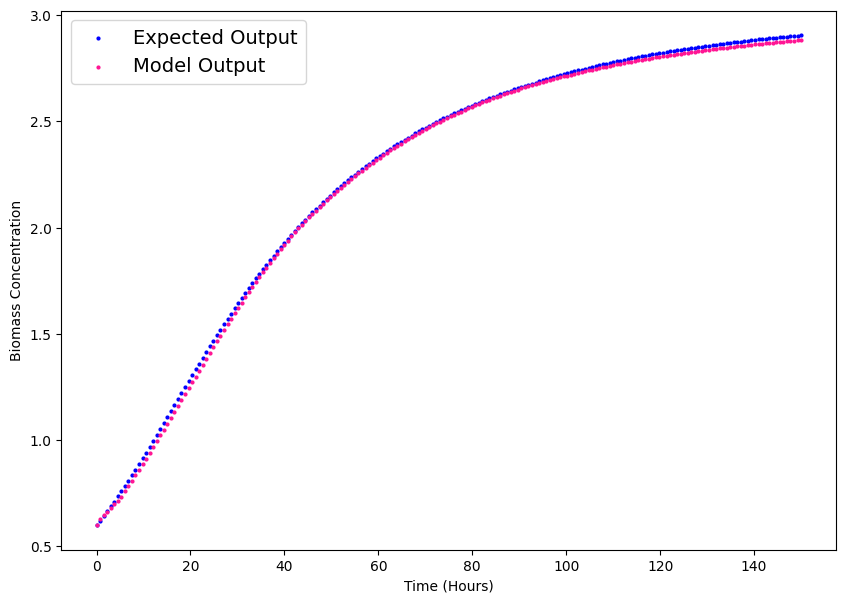

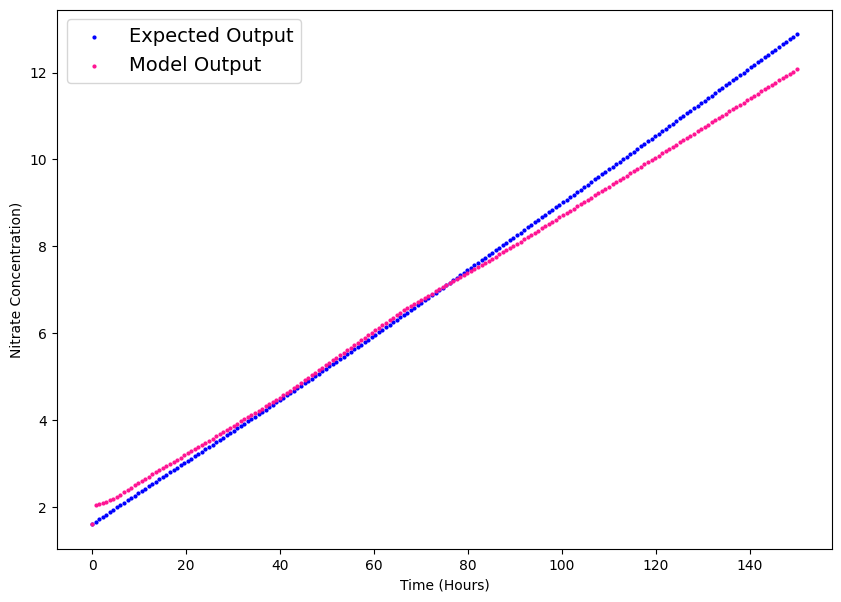

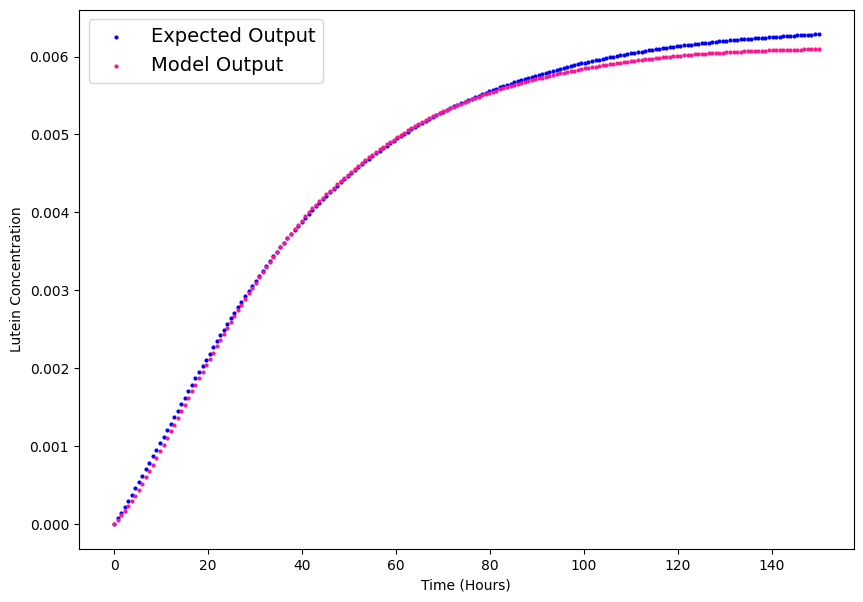

In [29]:
col = 0
#quick visual just to see our data
def plot_predictions(col = col,
                     train_data=XTimes, 
                     train_labels=X_exp, 
                     test_data=XTimes, 
                     test_labels=X_exp_pred, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7)) #create the base of our figure, figsize feeds in width/height in inches

  # Plot training data in blue
  plt.scatter(train_data, train_labels.iloc[:, col], c="b", s=4, label="Expected Output") #c for color, s for size. 
  
  # Plot test data in green
  plt.scatter(test_data, test_labels.iloc[:,col], c="deeppink", s=4, label="Model Output")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="seagreen", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});
  #Axes labels
  plt.xlabel("Time (Hours)")
  match col:
    case 0:
      plt.ylabel("Biomass Concentration")
    case 1:
      plt.ylabel("Nitrate Concentration)")
    case 2:
      plt.ylabel("Lutein Concentration")

plot_predictions(col=0)
plot_predictions(col=1)
plot_predictions(col=2)

# Final Steps
- we can go ahead and save the state of our predictions for if someone would want to analyse 'em later!

In [30]:
from pathlib import Path  
filepath = Path('outputs\PredExperiment.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  
X_exp_pred.to_csv(filepath) 
filepath = Path('outputs\ActualExperiment.csv')
X_exp.to_csv(filepath)